# change to 3 class classification

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from collections import Counter
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, KFold

In [3]:
def write_auc(config, roc_auc):
    file = write_path+'BDT_results.txt'
    with open(file, 'a+') as f:
        aucs = []
        for i in range(0, 3):
            aucs.append(roc_auc[i])
        auc_msg = ','.join(map(str, aucs))
        message = f'{config}; {auc_msg} \n'
        f.write(message)

In [4]:
def write_cm(config, cm_p, cm_e):
    file = write_path+'BDT_cm.txt'
    with open(file, 'a+') as f:
        cm_p_msg = ','.join(map(str, cm_p.flatten().tolist()))
        cm_e_msg = ','.join(map(str, cm_e.flatten().tolist()))
        message = f'{config}; {cm_p_msg}; {cm_e_msg} \n'
        f.write(message)

In [29]:
def plot_roc_curve(fpr, tpr, auc, i):
    ax.plot(fpr, tpr, label=f'{classes[i]} ROC score: {auc:.3f}')
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    plt.legend()

In [30]:
def plot_confusion_matrix(y_test, y_pred, classes, figname, w_test=None, normalise_by_col=False, normalise_by_row=False, cmap=plt.cm.Blues):
    if w_test is not None: cm = confusion_matrix(y_test, y_pred, sample_weight=w_test)
    else: cm = confusion_matrix(y_test, y_pred) 
    if normalise_by_col:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print ('Normalised efficiency confusion matrix')
    elif normalise_by_row:
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
        print ('Normalised purity confusion matrix')
    else:
        print ('Non-normalised confusion matrix')

    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='w' if cm[i, j] > thresh else 'k')

    plt.tight_layout(pad=1.4)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.savefig(figname)
    #print ('Confusion matrix saved as {}'.format(figname))
    return cm

In [31]:
path = '/vols/cms/dw515/Offline/output/SM/masters_signal_vs_background_combined/'
write_path = '/home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/'

In [32]:
vbfh_tree = uproot.open(path+'VBFH.root')['ntuple']
ztt_tree = uproot.open(path+'ZTT.root')['ntuple']
fakes_tree = uproot.open(path+'fakes.root')['ntuple']
ggh_tree = uproot.open(path+'ggH.root')['ntuple']

In [33]:
variables = ['pt_1','pt_2', 'm_vis','svfit_mass','mjj','jpt_1','pt_tt','met','n_jets','pt_vis','iso_1','iso_2', 'wt']
selectors = ['rand', 'wt_cp_sm', 'deepTauVsJets_medium_1', 'deepTauVsJets_medium_2', 'trg_doubletau', 'os']

In [34]:
vbfh = vbfh_tree.pandas.df(variables+selectors)
ztt = ztt_tree.pandas.df(variables+selectors)
fakes = fakes_tree.pandas.df(variables+selectors)
ggh = ggh_tree.pandas.df(variables+selectors)

In [35]:
vbfh = vbfh[vbfh['deepTauVsJets_medium_1'] & vbfh['deepTauVsJets_medium_2'] & vbfh['trg_doubletau'] & vbfh['os']]
ztt = ztt[ztt['deepTauVsJets_medium_1'] & ztt['deepTauVsJets_medium_2'] & ztt['trg_doubletau'] & ztt['os']]
fakes = fakes[fakes['deepTauVsJets_medium_1'] & fakes['deepTauVsJets_medium_2'] & fakes['trg_doubletau'] & (fakes['os']==0)]
ggh = ggh[ggh['deepTauVsJets_medium_1'] & ggh['deepTauVsJets_medium_2'] & ggh['trg_doubletau'] & ggh['os']]

In [36]:
scaling = {
    'ggh': 0.0022034,
    'vbfh': 0.0001486,
    'fakes': 1.35,
    'ztt': 3.6292,
}

In [37]:
vbfh.loc[:, 'w'] = vbfh.wt*vbfh.wt_cp_sm *scaling['vbfh']
ztt.loc[:, 'w'] = ztt.wt *scaling['ztt']
fakes.loc[:, 'w'] = fakes.wt *scaling['fakes']
ggh.loc[:, 'w'] = ggh.wt*ggh.wt_cp_sm *scaling['ggh']

In [38]:
vbfh.loc[:, 'h_ind'] = np.ones(vbfh.shape[0])
ztt.loc[:, 'h_ind'] = np.zeros(ztt.shape[0])
fakes.loc[:, 'h_ind'] = np.zeros(fakes.shape[0])
ggh.loc[:, 'h_ind'] = np.full((ggh.shape[0],),2.)

In [39]:
higgs = pd.concat([vbfh, ggh]).reset_index(drop=True)

In [40]:
higgs.loc[:, 'y'] = np.zeros(higgs.shape[0])
ztt.loc[:, 'y'] = np.ones(ztt.shape[0])
fakes.loc[:, 'y'] = np.full((fakes.shape[0],),2.)

In [41]:
higgs.loc[:, 'cn'] = np.full((higgs.shape[0],),928.278)
ztt.loc[:, 'cn'] = np.full((ztt.shape[0],),4.716)
fakes.loc[:, 'cn'] = np.full((fakes.shape[0],),1.278)

In [42]:
df = pd.concat([higgs, ztt, fakes]).reset_index(drop=True)

In [43]:
higgs.shape

(1263521, 23)

In [44]:
df = df[df.w > 0]

In [45]:
print(sorted(Counter(df.y).items()))

[(0.0, 1262736), (1.0, 33487), (2.0, 100831)]


In [46]:
higgs.w.sum(), ztt.w.sum(), fakes.w.sum()

(927.8508354332606, 36877.137177970326, 136121.85)

# 2 BDTs on 2 halves

### without iso variables

In [47]:
higgs = higgs.sample(frac=1).reset_index(drop=True)
higgs1 = higgs[:len(higgs)//2]
higgs2 = higgs[len(higgs)//2:]
ztt1 = ztt[:len(ztt)//2]
ztt2 = ztt[len(ztt)//2:]
fakes1 = fakes[:len(fakes)//2]
fakes2 = fakes[len(fakes)//2:]

df1 = pd.concat([higgs1, ztt1, fakes1]).reset_index(drop=True)
df2 = pd.concat([higgs2, ztt2, fakes2]).reset_index(drop=True)

In [48]:
df1 = df1[df1.w > 0]
df2 = df2[df2.w > 0]

In [49]:
df1_1 = df1.drop(selectors+['iso_1', 'iso_2'], axis=1)
df2_1 = df2.drop(selectors+['iso_1', 'iso_2'], axis=1)

In [50]:
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 3000, # !!! just for now, to  make it faster. It should be 3000
    "subsample": 0.9,
    "seed": 123451,
    #'tree_method':'gpu_hist',
}

xgb_clf1 = xgboost.XGBClassifier(**xgb_params)
xgb_clf2 = xgboost.XGBClassifier(**xgb_params)

In [51]:
df1_1.drop(['y', 'wt', 'w', 'cn', 'h_ind'], axis=1).columns
df2_1.drop(['y', 'wt', 'w', 'cn', 'h_ind'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis'],
      dtype='object')

In [52]:
X1 = df1_1.drop(['y', 'wt', 'w', 'cn', 'h_ind'], axis=1).to_numpy()
y1 = df1_1.y.astype(int)
w1 = df1_1.w
X_train1, X_test1, y_train1, y_test1, w_train1, w_test1, cn_train1, cn_test1, h_ind_train1, h_ind_test1 = train_test_split(X1, y1, w1, df1.cn, df1.h_ind, test_size=0.3, random_state=1, stratify=df1_1.y)

X2 = df2_1.drop(['y', 'wt', 'w', 'cn', 'h_ind'], axis=1).to_numpy()
y2 = df2_1.y.astype(int)
w2 = df2_1.w
X_train2, X_test2, y_train2, y_test2, w_train2, w_test2, cn_train2, cn_test2, h_ind_train2, h_ind_test2 = train_test_split(X2, y2, w2, df2.cn, df2.h_ind, test_size=0.3, random_state=1, stratify=df2_1.y)

In [53]:
eval_set1 = [(X_train1, y_train1), (X_test1, y_test1)]
xgb_clf1.fit(X_train1, y_train1, sample_weight=w_train1*cn_train1, 
                verbose=2, early_stopping_rounds=50, eval_set=eval_set1, 
                eval_metric = "mlogloss", sample_weight_eval_set=(w_train1*cn_train1, w_test1*cn_test1))

631	validation_1-mlogloss:0.39839
[1134]	validation_0-mlogloss:0.37628	validation_1-mlogloss:0.39839
[1136]	validation_0-mlogloss:0.37624	validation_1-mlogloss:0.39840
[1138]	validation_0-mlogloss:0.37621	validation_1-mlogloss:0.39839
[1140]	validation_0-mlogloss:0.37618	validation_1-mlogloss:0.39839
[1142]	validation_0-mlogloss:0.37614	validation_1-mlogloss:0.39839
[1144]	validation_0-mlogloss:0.37611	validation_1-mlogloss:0.39839
[1146]	validation_0-mlogloss:0.37608	validation_1-mlogloss:0.39839
[1148]	validation_0-mlogloss:0.37605	validation_1-mlogloss:0.39838
[1150]	validation_0-mlogloss:0.37601	validation_1-mlogloss:0.39837
[1152]	validation_0-mlogloss:0.37598	validation_1-mlogloss:0.39837
[1154]	validation_0-mlogloss:0.37595	validation_1-mlogloss:0.39838
[1156]	validation_0-mlogloss:0.37591	validation_1-mlogloss:0.39838
[1158]	validation_0-mlogloss:0.37588	validation_1-mlogloss:0.39837
[1160]	validation_0-mlogloss:0.37584	validation_1-mlogloss:0.39836
[1162]	validation_0-mlogloss

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [54]:
eval_set2 = [(X_train2, y_train2), (X_test2, y_test2)]
xgb_clf2.fit(X_train2, y_train2, sample_weight=w_train2*cn_train2, 
                verbose=2, early_stopping_rounds=50, eval_set=eval_set2, 
                eval_metric = "mlogloss", sample_weight_eval_set=(w_train2*cn_train2, w_test2*cn_test2))

1-mlogloss:0.49643
[628]	validation_0-mlogloss:0.47120	validation_1-mlogloss:0.49643
[630]	validation_0-mlogloss:0.47113	validation_1-mlogloss:0.49641
[632]	validation_0-mlogloss:0.47106	validation_1-mlogloss:0.49639
[634]	validation_0-mlogloss:0.47099	validation_1-mlogloss:0.49638
[636]	validation_0-mlogloss:0.47091	validation_1-mlogloss:0.49635
[638]	validation_0-mlogloss:0.47082	validation_1-mlogloss:0.49633
[640]	validation_0-mlogloss:0.47076	validation_1-mlogloss:0.49633
[642]	validation_0-mlogloss:0.47070	validation_1-mlogloss:0.49633
[644]	validation_0-mlogloss:0.47065	validation_1-mlogloss:0.49632
[646]	validation_0-mlogloss:0.47058	validation_1-mlogloss:0.49629
[648]	validation_0-mlogloss:0.47050	validation_1-mlogloss:0.49628
[650]	validation_0-mlogloss:0.47042	validation_1-mlogloss:0.49628
[652]	validation_0-mlogloss:0.47035	validation_1-mlogloss:0.49627
[654]	validation_0-mlogloss:0.47030	validation_1-mlogloss:0.49627
[656]	validation_0-mlogloss:0.47024	validation_1-mlogloss

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [55]:
y_pred1 = xgb_clf1.predict_proba(X_test2)
onehot1=label_binarize(y_test2,classes=[0,1,2])
fpr1=dict()
tpr1=dict()
thresh1 = dict()
roc_auc1=dict()
for i in range(3):
    fpr1[i], tpr1[i], thresh1[i] = roc_curve(onehot1[:,i], y_pred1[:,i],sample_weight=w_test2)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])

y_pred2 = xgb_clf2.predict_proba(X_test1)
onehot2=label_binarize(y_test1,classes=[0,1,2])
fpr2=dict()
tpr2=dict()
thresh2 = dict()
roc_auc2=dict()
for i in range(3):
    fpr2[i], tpr2[i], thresh2[i] = roc_curve(onehot2[:,i], y_pred2[:,i],sample_weight=w_test1)
    roc_auc2[i] = auc(fpr2[i], tpr2[i])

In [56]:
y_classes1 = xgb_clf1.predict(X_test2)
y_classes2 = xgb_clf2.predict(X_test1)

In [57]:
print(h_ind_test2.shape)
print(y_pred1[:, 0].shape)
print(y_classes1.shape)

(209561,)
(209561,)
(209561,)


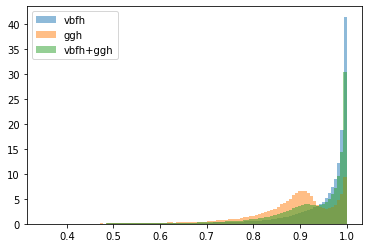

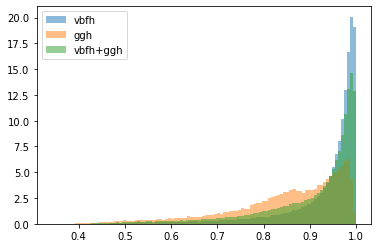

In [58]:
plt.figure()
# plt.hist(y_pred[:, 0][y_test==0], bins=100, label='higgs', alpha=0.5, density=True)
plt.hist(y_pred1[:, 0][(y_classes1==0) & (h_ind_test2==1)], bins=100, label='vbfh', alpha=0.5, density=True)
plt.hist(y_pred1[:, 0][(y_classes1==0) & (h_ind_test2==2)], bins=100, label='ggh', alpha=0.5, density=True)
plt.hist(np.append(y_pred1[:, 0][(y_classes1==0) & (h_ind_test2==1)], y_pred1[:, 0][(y_classes1==0) & (h_ind_test2==2)]), bins=100, label='vbfh+ggh', alpha=0.5, density=True)
plt.legend()
#plt.savefig('./signal_background/higgs_vbf_ggh_score.PNG')
plt.show()

plt.figure()
# plt.hist(y_pred[:, 0][y_test==0], bins=100, label='higgs', alpha=0.5, density=True)
plt.hist(y_pred2[:, 0][(y_classes2==0) & (h_ind_test1==1)], bins=100, label='vbfh', alpha=0.5, density=True)
plt.hist(y_pred2[:, 0][(y_classes2==0) & (h_ind_test1==2)], bins=100, label='ggh', alpha=0.5, density=True)
plt.hist(np.append(y_pred2[:, 0][(y_classes2==0) & (h_ind_test1==1)], y_pred2[:, 0][(y_classes2==0) & (h_ind_test1==2)]), bins=100, label='vbfh+ggh', alpha=0.5, density=True)
plt.legend()
#plt.savefig('./signal_background/higgs_vbf_ggh_score.PNG')
plt.show()

In [59]:
# THIS CELL IS WRONG AND IT WILL PROBABLY DELETED IN THE FEATURE

y_pred1 = xgb_clf1.predict_proba(X2)
y_classes1 = xgb_clf1.predict(X2)
higgs_events1 = y_classes1==0
higgs_prob1 = y_pred1[higgs_events1][:, 0]

print(higgs_prob1.shape)
#print(vbfmask_test2)
print(np.sum(np.isnan(vbfmask_test2)))
vbfmask_test2[np.isnan(vbfmask_test2)] = 0 # this is problematic! The problem is that some events will be
# classified as higgs even if they are not higgs events. What do we say then? Are they vbfh or ggh in this case?
# for now I just say that they are ggh-s

#vbfh_prob1 = higgs_prob1[vbfmask_test2.astype(int)]
#ggh_prob1 = higgs_prob1[~vbfmask_test2.astype(int)]
vbfh_prob1 = y_pred1[higgs_events1][vbfmask_test2.astype(int)][:, 0]
ggh_prob1 = y_pred1[higgs_events1][~vbfmask_test2.astype(int)][:, 0]

plt.title('Higgs scores')
plt.hist(higgs_prob1, bins=100, alpha=0.5, label='higgs')
plt.hist(vbfh_prob1, bins=100, alpha=0.5, label='vbfh')
plt.hist(ggh_prob1, bins=100, alpha=0.5, label='ggh')
plt.ylabel('frequency')
plt.xlabel('Higgs score')
plt.legend()

(645742,)


NameError: name 'vbfmask_test2' is not defined

Text(0.5, 1.0, 'Trained on 2nd half, evaluated on 1st half')

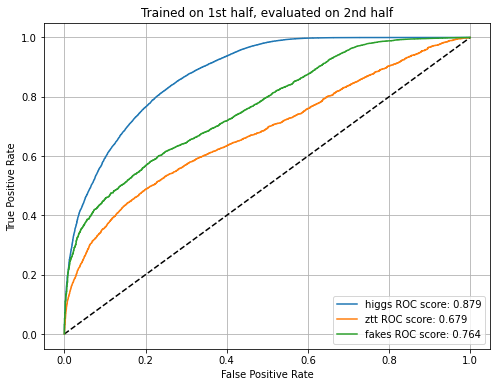

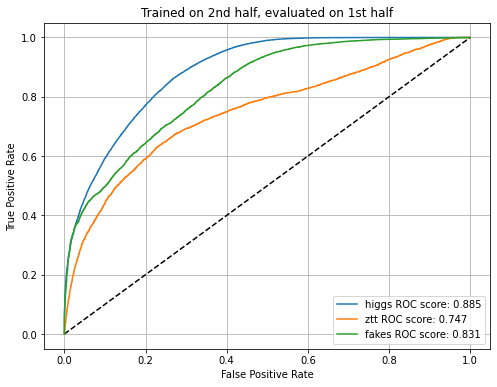

In [67]:
classes = ['higgs', 'ztt', 'fakes']
fig, ax = plt.subplots(figsize=(8,6))
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr1)):
    plot_roc_curve(fpr1[i],tpr1[i],roc_auc1[i], i)
plt.title('Trained on 1st half, evaluated on 2nd half')

classes = ['higgs', 'ztt', 'fakes']
fig, ax = plt.subplots(figsize=(8,6))
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr2)):
    plot_roc_curve(fpr2[i],tpr2[i],roc_auc2[i], i)
plt.title('Trained on 2nd half, evaluated on 1st half')

In [68]:
cr1 = classification_report(y_test2, xgb_clf1.predict(X_test2), output_dict=True, target_names=classes, sample_weight=w_test2)
pd.DataFrame(cr1).transpose()

,precision,recall,f1-score,support
higgs,0.010280,0.971580,0.020344,138.681141
ztt,0.658687,0.246126,0.358350,7292.383163
fakes,0.897209,0.528066,0.664834,20418.750000
accuracy,0.456450,0.456450,0.456450,0.456450
macro avg,0.522059,0.581924,0.347843,27849.814304
weighted avg,0.830336,0.456450,0.581373,27849.814304


In [69]:
cr2 = classification_report(y_test1, xgb_clf2.predict(X_test1), output_dict=True, target_names=classes, sample_weight=w_test1)
pd.DataFrame(cr2).transpose()

,precision,recall,f1-score,support
higgs,0.013510,0.958255,0.026644,140.318717
ztt,0.426830,0.461055,0.443283,3808.188067
fakes,0.966147,0.487405,0.647937,20418.750000
accuracy,0.485998,0.485998,0.485998,0.485998
macro avg,0.468829,0.635572,0.372621,24367.256785
weighted avg,0.876375,0.485998,0.612375,24367.256785


Normalised purity confusion matrix
[[1.02798629e-02 9.50014123e-04 1.12555107e-04]
 [3.25285550e-01 6.58686951e-01 1.02678587e-01]
 [6.64434587e-01 3.40363035e-01 8.97208858e-01]]
Normalised efficiency confusion matrix
[[0.97157984 0.01866641 0.00975375]
 [0.58466066 0.24612612 0.16921323]
 [0.4265124  0.04542149 0.52806612]]


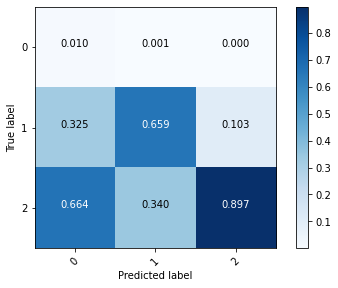

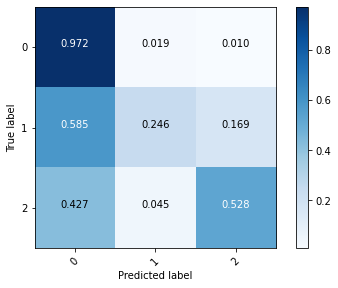

In [70]:
predict1=xgb_clf1.predict(X_test2)
cm_p1=plot_confusion_matrix(y_test2, predict1, [0,1,2],
                    normalise_by_row=True, w_test=w_test2, figname=f'{write_path}purity.png')
cm_e1=plot_confusion_matrix(y_test2, predict1, [0,1,2],
                    normalise_by_col=True, w_test=w_test2, figname=f'{write_path}efficiency.png')

Normalised purity confusion matrix
[[1.35098867e-02 1.14459208e-03 1.11564436e-04]
 [1.71292203e-01 4.26830440e-01 3.37412284e-02]
 [8.15197911e-01 5.72024968e-01 9.66147207e-01]]
Normalised efficiency confusion matrix
[[0.95825542 0.03355454 0.00819004]
 [0.44767659 0.46105546 0.09126795]
 [0.39735537 0.11523967 0.48740496]]


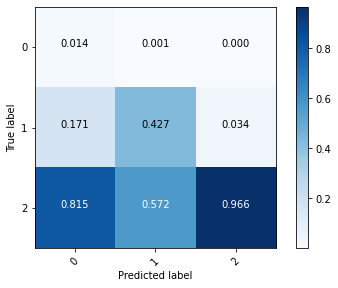

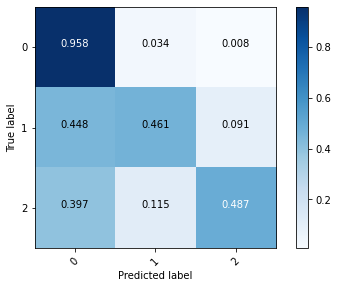

In [71]:
predict2=xgb_clf2.predict(X_test1)
cm_p2=plot_confusion_matrix(y_test1, predict2, [0,1,2],
                    normalise_by_row=True, w_test=w_test1, figname=f'{write_path}purity.png')
cm_e2=plot_confusion_matrix(y_test1, predict2, [0,1,2],
                    normalise_by_col=True, w_test=w_test1, figname=f'{write_path}efficiency.png')

In [72]:
def SsqrtBPlot(xgb_clf, X, df_1, y):
    y_pred = xgb_clf.predict_proba(X)
    y_classes = xgb_clf.predict(X)
    higgs_events = y_classes==0
    higgs_prob = y_pred[higgs_events][:, 0]
    filtered_mask = (higgs_prob>0.9) & (higgs_prob<1)
    filtered_higgs_prob = higgs_prob[filtered_mask]
    def filterprob(start, end):
        filtered_mask = (higgs_prob>start) & (higgs_prob<end)
        filtered_higgs_prob = higgs_prob[filtered_mask]
        return filtered_mask, filtered_higgs_prob
    fig, ax = plt.subplots(1, 4, sharex='col', sharey='row', figsize=(24,6))
    windows = [[0, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1]]
    for i, w in enumerate(windows):
        filtered_mask, filtered_higgs_prob = filterprob(w[0], w[1])
    #     counts = Counter(y_classes[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])])
    #     counts =Counter(y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])])
        S = df_1.w[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])][y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])]==0].sum()
        ztt = df_1.w[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])][y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])]==1].sum()
        fakes = df_1.w[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])][y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])]==2].sum()
        B = ztt + fakes
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    #     ax[i].set_xlim(w[0], w[1])
        textstr= f"S/sqrt(B)={S/np.sqrt(B):.4f}\nS={S:.3f}\nztt={ztt:.3f}\nfakes={fakes:.3f}"
        ax[i].text(0.05, 0.95, textstr, transform=ax[i].transAxes, fontsize=14, horizontalalignment='left', verticalalignment='top', bbox=props)
        ax[i].hist(filtered_higgs_prob, bins=100)
    plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Trained on the first half, evaluated on the second half:


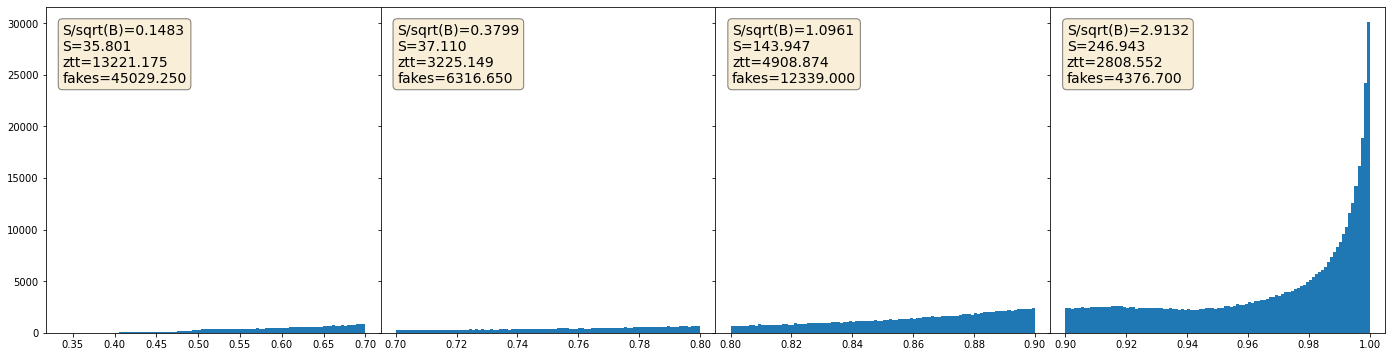

In [73]:
print('Trained on the first half, evaluated on the second half:')
SsqrtBPlot(xgb_clf1, X2, df2_1, y2)

Trained on the second half, evaluated on the first half:


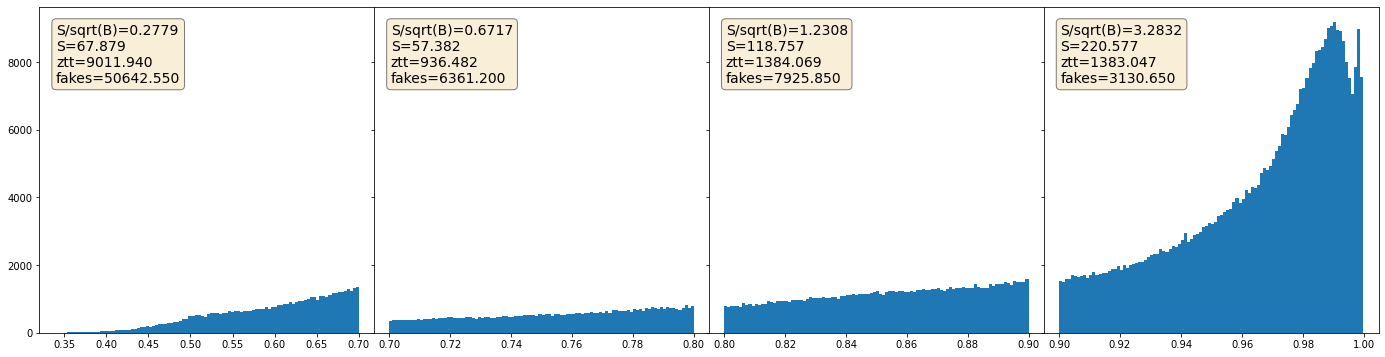

In [74]:
print('Trained on the second half, evaluated on the first half:')
SsqrtBPlot(xgb_clf2, X1, df1_1, y1)

### 2 folds plotted together

In [76]:
y_pred1 = xgb_clf1.predict_proba(X_test2)
onehot1=label_binarize(y_test2,classes=[0,1,2])

y_pred2 = xgb_clf2.predict_proba(X_test1)
onehot2=label_binarize(y_test1,classes=[0,1,2])

y_pred = np.concatenate([y_pred1, y_pred2])#.reset_index(drop=True)
onehot = np.concatenate([onehot1, onehot2])#.reset_index(drop=True)
w_test = np.concatenate([w_test1, w_test2])#.reset_index(drop=True)

fpr=dict()
tpr=dict()
thresh = dict()
roc_auc=dict()
for i in range(3):
    fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred[:,i],sample_weight=w_test)
    roc_auc[i] = auc(fpr[i], tpr[i])

Text(0.5, 1.0, '2 fold analysis plotted together')

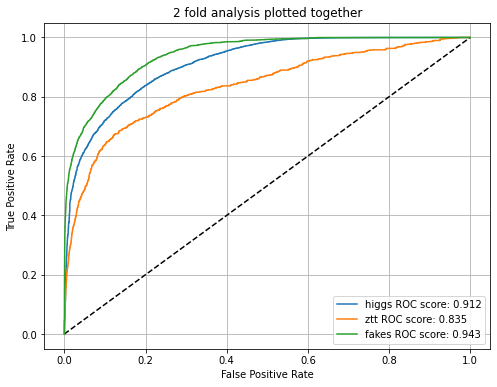

In [77]:
classes = ['higgs', 'ztt', 'fakes']
fig, ax = plt.subplots(figsize=(8,6))
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr)):
    plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
plt.title('2 fold analysis plotted together')

In [78]:
y_test = pd.concat([y_test1, y_test2]).reset_index(drop=True)
y_pred1 = xgb_clf1.predict(X_test2)
y_pred2 = xgb_clf2.predict(X_test1)
y_pred = np.concatenate([y_pred1, y_pred2])#.reset_index(drop=True)

cr = classification_report(y_test, y_pred, output_dict=True, target_names=classes, sample_weight=w_test)
pd.DataFrame(cr).transpose()

,precision,recall,f1-score,support
higgs,0.005327,0.918015,0.010593,278.999858
ztt,0.209844,0.035261,0.060377,11100.571230
fakes,0.798729,0.044496,0.084296,40837.500000
accuracy,0.047200,0.047200,0.047200,0.047200
macro avg,0.337967,0.332590,0.051755,52217.071088
weighted avg,0.669302,0.047200,0.078817,52217.071088


Normalised purity confusion matrix
[[0.00532743 0.00560884 0.00545579]
 [0.21348502 0.20984371 0.19581493]
 [0.78118755 0.78454745 0.79872928]]
Normalised efficiency confusion matrix
[[0.9180146  0.03749844 0.04448696]
 [0.92460804 0.03526099 0.04013097]
 [0.91966942 0.03583471 0.04449587]]


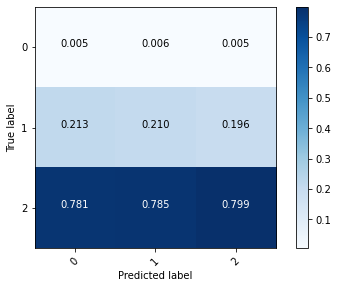

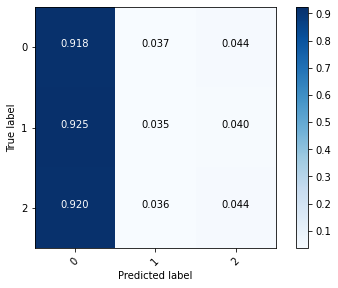

In [79]:
cm_p1=plot_confusion_matrix(y_test, y_pred, [0,1,2],
                    normalise_by_row=True, w_test=w_test, figname=f'{write_path}purity.png')
cm_e1=plot_confusion_matrix(y_test, y_pred, [0,1,2],
                    normalise_by_col=True, w_test=w_test, figname=f'{write_path}efficiency.png')

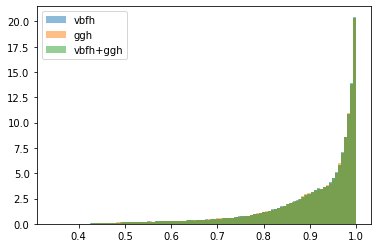

In [81]:
h_ind_test = pd.concat([h_ind_test1, h_ind_test2]).reset_index(drop=True)
y_pred_proba1 = xgb_clf1.predict_proba(X_test2)
y_pred_proba2 = xgb_clf2.predict_proba(X_test1)
y_pred_proba = np.concatenate([y_pred_proba1, y_pred_proba2])#.reset_index(drop=True)

plt.figure()
# plt.hist(y_pred[:, 0][y_test==0], bins=100, label='higgs', alpha=0.5, density=True)
plt.hist(y_pred_proba[:, 0][(y_pred==0) & (h_ind_test==1)], bins=100, label='vbfh', alpha=0.5, density=True)
plt.hist(y_pred_proba[:, 0][(y_pred==0) & (h_ind_test==2)], bins=100, label='ggh', alpha=0.5, density=True)
plt.hist(np.append(y_pred_proba[:, 0][(y_pred==0) & (h_ind_test==1)], y_pred_proba[:, 0][(y_pred==0) & (h_ind_test==2)]), bins=100, label='vbfh+ggh', alpha=0.5, density=True)
plt.legend()
#plt.savefig('./signal_background/higgs_vbf_ggh_score.PNG')
plt.show()

In [82]:
def SsqrtBPlotTogether(xgb_clf1, xgb_clf2, X1, X2, df1_1, df2_1, y1, y2):
    y_pred1 = xgb_clf1.predict_proba(X2)
    y_classes1 = xgb_clf1.predict(X2)
    y_pred2 = xgb_clf2.predict_proba(X1)
    y_classes2 = xgb_clf2.predict(X1)
    y_pred = np.concatenate([y_pred1, y_pred2])
    y_classes = np.concatenate([y_classes1, y_classes2])

    df_1 = pd.concat([df1_1, df2_1])
    y = pd.concat([y1, y2])

    higgs_events = y_classes==0
    higgs_prob = y_pred[higgs_events][:, 0]
    filtered_mask = (higgs_prob>0.9) & (higgs_prob<1)
    filtered_higgs_prob = higgs_prob[filtered_mask]
    def filterprob(start, end):
        filtered_mask = (higgs_prob>start) & (higgs_prob<end)
        filtered_higgs_prob = higgs_prob[filtered_mask]
        return filtered_mask, filtered_higgs_prob
    fig, ax = plt.subplots(1, 4, sharex='col', sharey='row', figsize=(24,6))
    windows = [[0, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1]]
    for i, w in enumerate(windows):
        filtered_mask, filtered_higgs_prob = filterprob(w[0], w[1])
    #     counts = Counter(y_classes[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])])
    #     counts =Counter(y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])])
        S = df_1.w[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])][y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])]==0].sum()
        ztt = df_1.w[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])][y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])]==1].sum()
        fakes = df_1.w[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])][y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])]==2].sum()
        B = ztt + fakes
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    #     ax[i].set_xlim(w[0], w[1])
        textstr= f"S/sqrt(B)={S/np.sqrt(B):.4f}\nS={S:.3f}\nztt={ztt:.3f}\nfakes={fakes:.3f}"
        ax[i].text(0.05, 0.95, textstr, transform=ax[i].transAxes, fontsize=14, horizontalalignment='left', verticalalignment='top', bbox=props)
        ax[i].hist(filtered_higgs_prob, bins=100)
    plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

2 fold analysis plotted together:


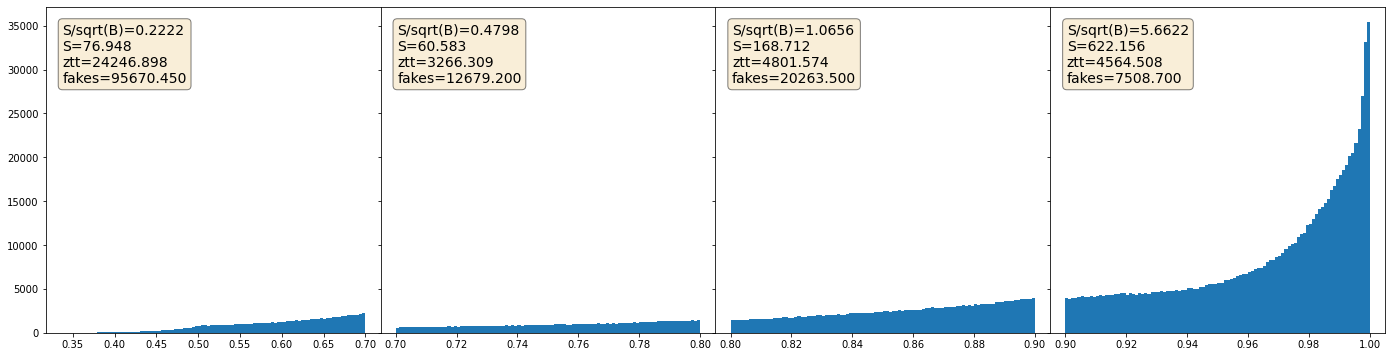

In [83]:
print('2 fold analysis plotted together:')
SsqrtBPlotTogether(xgb_clf1, xgb_clf2, X1, X2, df1_1, df2_1, y1, y2)

In [61]:
def SsqrtBPlotKristof(xgb_clf, X, df_1, y):
    y_pred = xgb_clf.predict_proba(X)
    y_classes = xgb_clf.predict(X)
    higgs_events = y_classes==0
    higgs_prob = y_pred[higgs_events][:, 0]
    #filtered_mask = (higgs_prob>0.9) & (higgs_prob<1)
    #filtered_higgs_prob = higgs_prob[filtered_mask]
    #def filterprob(start, end):
    #    filtered_mask = (higgs_prob>start) & (higgs_prob<end)
    #    filtered_higgs_prob = higgs_prob[filtered_mask]
    #    return filtered_mask, filtered_higgs_prob
    #fig, ax = plt.subplots(1, 4, sharex='col', sharey='row', figsize=(24,6))
    #windows = [[0, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1]]
    #windows = list(zip(np.linspace(0, 0.99, 100), np.linspace(0.01, 1, 100)))
    #for i, w in enumerate(windows):
    #    filtered_mask, filtered_higgs_prob = filterprob(w[0], w[1])
    ##     counts = Counter(y_classes[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])])
    ##     counts =Counter(y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])])

        #S = df_1.w[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])][y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])]==0].sum()
        #ztt = df_1.w[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])][y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])]==1].sum()
        #fakes = df_1.w[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])][y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])]==2].sum()
        #B = ztt + fakes

    plt.title('Higgs scores')
    plt.hist(higgs_prob, bins=100)
    plt.ylabel('frequency')
    plt.xlabel('Higgs score')

        #props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    #     ax[i].set_xlim(w[0], w[1])
        #textstr= f"S/sqrt(B)={S/np.sqrt(B):.4f}\nS={S:.3f}\nztt={ztt:.3f}\nfakes={fakes:.3f}"
        #ax[i].text(0.05, 0.95, textstr, transform=ax[i].transAxes, fontsize=14, horizontalalignment='left', verticalalignment='top', bbox=props)
        #ax[i].hist(filtered_higgs_prob, bins=100)
    #plt.subplots_adjust(wspace=0, hspace=0)
#plt.show()

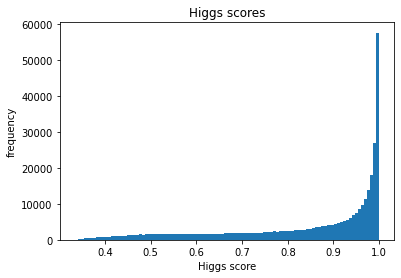

In [55]:
SsqrtBPlotKristof(xgb_clf1, X2, df2_1, y2)

### with iso variables

# base case

In [106]:
df_1 = df.drop(selectors+['iso_1', 'iso_2'], axis=1)

In [107]:
# xgb_params = {
#     "objective": "multi:softmax",
#     "max_depth": 6,
#     "num_classes": 4,
# }
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 3000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf = xgboost.XGBClassifier(**xgb_params)
# xgb_clf = xgboost.XGBClassifier()


In [108]:
df_1.drop(['y', 'wt', 'w', 'cn'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis'],
      dtype='object')

In [109]:
X = df_1.drop(['y', 'wt', 'w', 'cn'], axis=1).to_numpy()
y = df_1.y.astype(int)
w = df_1.w
X_train, X_test, y_train, y_test, w_train, w_test, cn_train, cn_test= train_test_split(X, y, w, df.cn, test_size=0.3, random_state=1, stratify=df_1.y)

In [110]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf.fit(X_train, y_train, sample_weight=w_train*cn_train, 
                verbose=2, early_stopping_rounds=50, eval_set=eval_set, 
                eval_metric = "mlogloss", sample_weight_eval_set=(w_train*cn_train, w_test*cn_test))
# xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, eval_metric="mlogloss")

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:09:35] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.05769	validation_1-mlogloss:1.05757
[2]	validation_0-mlogloss:0.98584	validation_1-mlogloss:0.98543
[4]	validation_0-mlogloss:0.92501	validation_1-mlogloss:0.92440
[6]	validation_0-mlogloss:0.87290	validation_1-mlogloss:0.87208
[8]	validation_0-mlogloss:0.82809	validation_1-mlogloss:0.82707
[10]	validation_0-mlogloss:0.78907	validation_1-mlogloss:0.78790
[12]	validation_0-mlogloss:0.75511	validation_1-mlogloss:0.75382
[14]	validation_0-mlogloss:0.72562	validation_1-mlogloss:0.72422
[16]	validation_0-mlogloss:0.69985	validation_1-mlogloss:0.69837
[18]	validation_0-mlogloss:0.67727	validation_1-mlogloss:0.67567
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [26]:
# skf = StratifiedKFold(n_splits=5)
# for train, test in skf.split(X, y):
#     xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, early_stopping_rounds=50, eval_set=eval_set, eval_metric = "mlogloss", sample_weight_eval_set=(w_train, w_test)

In [74]:
y_pred = xgb_clf.predict_proba(X_test)
onehot=label_binarize(y_test,classes=[0,1,2])
fpr=dict()
tpr=dict()
thresh = dict()
roc_auc=dict()
for i in range(3):
    fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred[:,i],sample_weight=w_test)
    roc_auc[i] = auc(fpr[i], tpr[i])

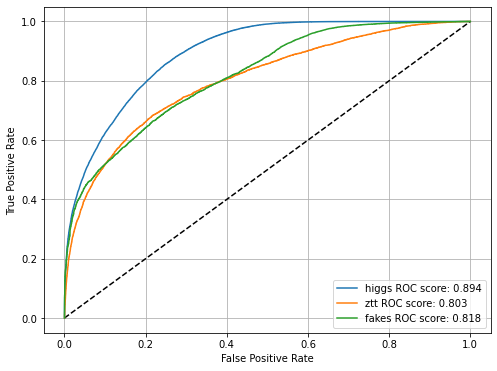

In [75]:
classes = ['higgs', 'ztt', 'fakes']
fig, ax = plt.subplots(figsize=(8,6))
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr)):
    plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
# plot_roc_curve(fpr[1],tpr[1],roc_auc[1], 1)
# plot_roc_curve(fpr[2],tpr[2],roc_auc[2], 2)
# plot_roc_curve(fpr[3],tpr[3],roc_auc[3], 3)
# plt.savefig('/signal_background/eda/roc_curves.png')
# 0.792, 0.791, 0.885

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


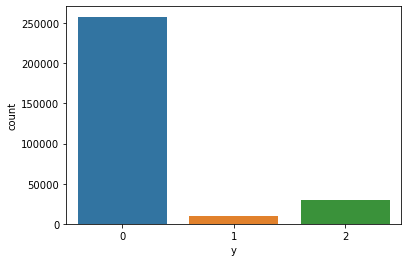

In [28]:
sns.countplot(y_test)
plt.show()

In [27]:
write_auc('base', roc_auc)

In [58]:
cr = classification_report(y_test, xgb_clf.predict(X_test), output_dict=True, target_names=classes, sample_weight=w_test)
pd.DataFrame(cr).transpose()

,precision,recall,f1-score,support
higgs,0.012499,0.966965,0.024678,279.545650
ztt,0.619036,0.471111,0.535037,11039.960088
fakes,0.950884,0.515224,0.668325,40836.150000
accuracy,0.508307,0.508307,0.508307,0.508307
macro avg,0.527473,0.651100,0.409347,52155.655738
weighted avg,0.875611,0.508307,0.636661,52155.655738


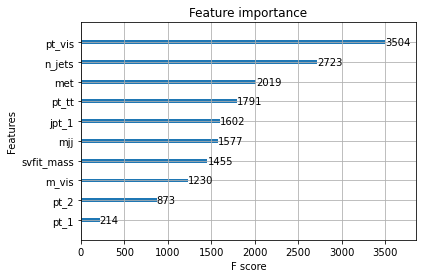

In [29]:
xgboost.plot_importance(xgb_clf).set_yticklabels(df_1.drop(['y','wt','w'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_weight.png')
plt.show()

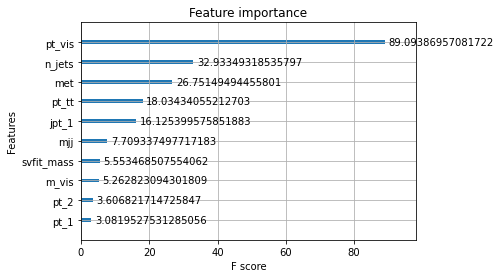

In [30]:
xgboost.plot_importance(xgb_clf, importance_type='gain').set_yticklabels(df_1.drop(['y','wt','w'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_gain.png')
plt.show()

Normalised purity confusion matrix
[[1.24964622e-02 8.00407409e-04 1.12355379e-04]
 [2.19815702e-01 6.14337322e-01 4.77893267e-02]
 [7.67687836e-01 3.84862271e-01 9.52098318e-01]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/purity.png
Normalised efficiency confusion matrix
[[0.96675837 0.02439576 0.00884587]
 [0.43060077 0.47412771 0.09527151]
 [0.40655889 0.08030018 0.51314093]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/efficiency.png


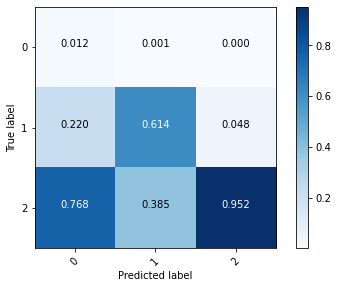

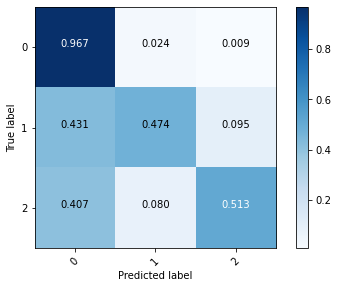

In [72]:
predict=xgb_clf.predict(X_test)
cm_p=plot_confusion_matrix(y_test, predict, [0,1,2],
                    normalise_by_row=True, w_test=w_test, figname=f'{write_path}purity.png')
cm_e=plot_confusion_matrix(y_test, predict, [0,1,2],
                    normalise_by_col=True, w_test=w_test, figname=f'{write_path}efficiency.png')

In [32]:
write_cm('base', cm_p, cm_e)

In [30]:
y_classes=xgb_clf.predict(X_test)

In [31]:
y_pred = xgb_clf.predict_proba(X_test)

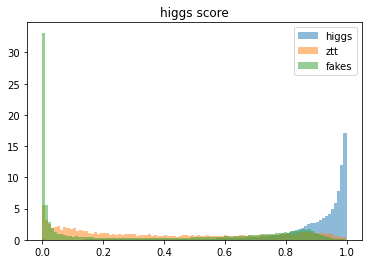

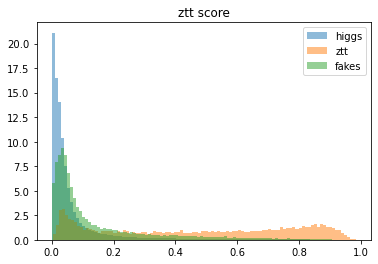

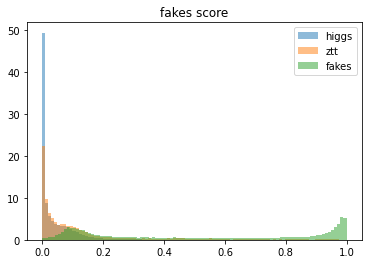

In [76]:
labels=['higgs', 'ztt', 'fakes']
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 0][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[0]+' score')
plt.legend()
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 1][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[1]+' score')
plt.legend()
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 2][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[2]+' score')
plt.legend()
plt.show()

# with iso variables

In [77]:
df_2 = df.drop(selectors, axis=1)

In [78]:
print(sorted(Counter(df_2.y).items()))

[(0.0, 1262736), (1.0, 33487), (2.0, 100831)]


In [80]:
# xgb_params = {
#     "objective": "multi:softmax",
#     "max_depth": 6,
#     "num_classes": 4,
# }
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 3000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf_iso = xgboost.XGBClassifier(**xgb_params)
# xgb_clf = xgboost.XGBClassifier()

In [81]:
df_2.drop(['y', 'wt', 'w', 'cn'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis', 'iso_1', 'iso_2'],
      dtype='object')

In [96]:
X_iso = df_2.drop(['y', 'wt', 'w', 'cn'], axis=1).to_numpy()
y_iso = df_2.y.astype(int)
w_iso = df_2.w
X_train, X_test, y_train, y_test, w_train, w_test, cn_train, cn_test= train_test_split(X_iso, y_iso, w_iso, df.cn, test_size=0.3, random_state=1, stratify=df_2.y)

In [97]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf_iso.fit(X_train, y_train, sample_weight=w_train*cn_train, 
                verbose=2, early_stopping_rounds=50, eval_set=eval_set, 
                eval_metric = "mlogloss", sample_weight_eval_set=(w_train*cn_train, w_test*cn_test))
# xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, eval_metric="mlogloss")

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:50:00] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.05679	validation_1-mlogloss:1.05676
[2]	validation_0-mlogloss:0.98316	validation_1-mlogloss:0.98298
[4]	validation_0-mlogloss:0.92054	validation_1-mlogloss:0.92030
[6]	validation_0-mlogloss:0.86669	validation_1-mlogloss:0.86634
[8]	validation_0-mlogloss:0.82017	validation_1-mlogloss:0.81971
[10]	validation_0-mlogloss:0.77957	validation_1-mlogloss:0.77906
[12]	validation_0-mlogloss:0.74425	validation_1-mlogloss:0.74368
[14]	validation_0-mlogloss:0.71327	validation_1-mlogloss:0.71264
[16]	validation_0-mlogloss:0.68609	validation_1-mlogloss:0.68546
[18]	validation_0-mlogloss:0.66202	validation_1-mlogloss:0.66134
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [42]:
X = df_2.drop(['y', 'wt', 'w', 'cn'], axis=1).to_numpy()
y = df_2.y.astype(int)
w = df_2.w
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.3, random_state=1, stratify=df_2.y)

In [43]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf_iso.fit(X_train, y_train, sample_weight=w_train, 
                verbose=2, early_stopping_rounds=50, eval_set=eval_set, 
                eval_metric = "mlogloss", sample_weight_eval_set=(w_train, w_test))

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:50:23] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.04747	validation_1-mlogloss:1.04743
[2]	validation_0-mlogloss:0.95749	validation_1-mlogloss:0.95736
[4]	validation_0-mlogloss:0.88089	validation_1-mlogloss:0.88071
[6]	validation_0-mlogloss:0.81524	validation_1-mlogloss:0.81503
[8]	validation_0-mlogloss:0.75840	validation_1-mlogloss:0.75829
[10]	validation_0-mlogloss:0.70887	validation_1-mlogloss:0.70895
[12]	validation_0-mlogloss:0.66540	validation_1-mlogloss:0.66565
[14]	validation_0-mlogloss:0.62727	validation_1-mlogloss:0.62763
[16]	validation_0-mlogloss:0.59374	validation_1-mlogloss:0.59446
[18]	validation_0-mlogloss:0.56389	validation_1-mlogloss:0.56473
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [44]:
y_pred = xgb_clf_iso.predict_proba(X_test)
onehot=label_binarize(y_test,classes=[0,1,2])
fpr=dict()
tpr=dict()
thresh = dict()
roc_auc=dict()
for i in range(3):
    fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred[:,i],sample_weight=w_test)
    roc_auc[i] = auc(fpr[i], tpr[i])

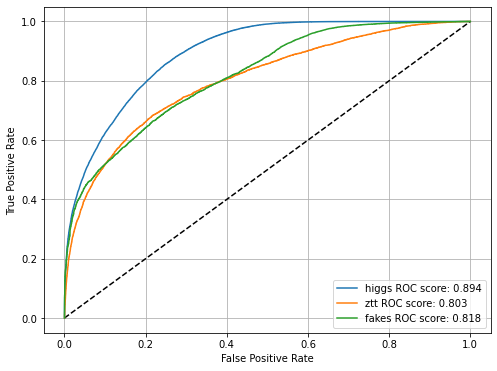

In [84]:
classes = ['higgs', 'ztt', 'fakes']
fig, ax = plt.subplots(figsize=(8,6))
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr)):
    plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
# plot_roc_curve(fpr[1],tpr[1],roc_auc[1], 1)
# plot_roc_curve(fpr[2],tpr[2],roc_auc[2], 2)
# plot_roc_curve(fpr[3],tpr[3],roc_auc[3], 3)
# plt.savefig('/signal_background/eda/roc_curves.png')

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


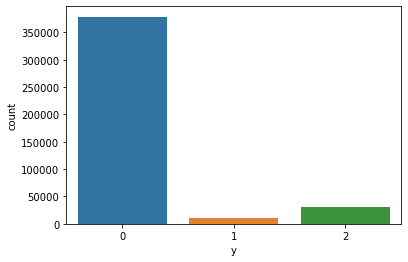

In [50]:
sns.countplot(y_test)
plt.show()

In [42]:
write_auc('with_iso', roc_auc)

In [85]:
cr = classification_report(y_test, xgb_clf_iso.predict(X_test), output_dict=True, target_names=classes, sample_weight=w_test)
pd.DataFrame(cr).transpose()

,precision,recall,f1-score,support
higgs,0.015546,0.956612,0.030594,279.545650
ztt,0.724045,0.497688,0.589897,11039.960088
fakes,0.965793,0.647195,0.775029,40836.150000
accuracy,0.617207,0.617207,0.617207,0.617207
macro avg,0.568461,0.700498,0.465174,52155.655738
weighted avg,0.909528,0.617207,0.731852,52155.655738


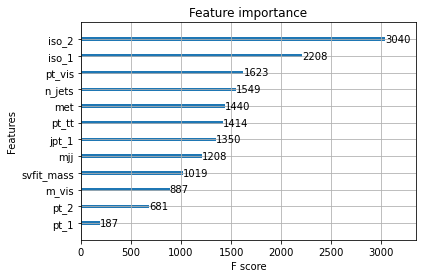

In [51]:
xgboost.plot_importance(xgb_clf_iso).set_yticklabels(df_2.drop(['y','wt','w','cn'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_weight_with_iso.png')
plt.show()

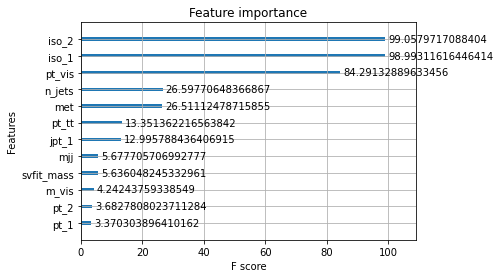

In [52]:
xgboost.plot_importance(xgb_clf_iso, importance_type='gain').set_yticklabels(df_2.drop(['y','wt','w','cn'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_gain_with_iso.png')
plt.show()

Normalised purity confusion matrix
[[1.55455986e-02 9.22690368e-04 1.87361942e-04]
 [2.68256036e-01 7.24044831e-01 3.40194332e-02]
 [7.16198365e-01 2.75032478e-01 9.65793205e-01]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/purity_with_iso.png
Normalised efficiency confusion matrix
[[0.95661155 0.02504739 0.01834106]
 [0.41798713 0.49768807 0.0843248 ]
 [0.30169592 0.05110913 0.64719495]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/efficiency_with_iso.png


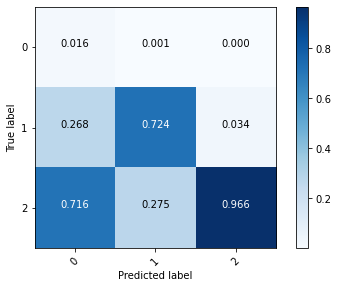

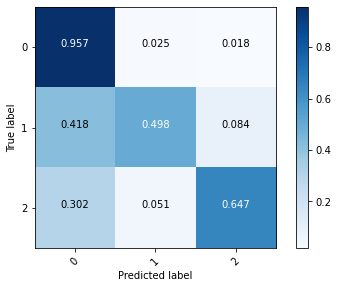

In [86]:
predict=xgb_clf_iso.predict(X_test)
cm_p=plot_confusion_matrix(y_test, predict, [0,1,2],
                    normalise_by_row=True, w_test=w_test, figname=f'{write_path}purity_with_iso.png')
cm_e=plot_confusion_matrix(y_test, predict, [0,1,2],
                    normalise_by_col=True, w_test=w_test, figname=f'{write_path}efficiency_with_iso.png')

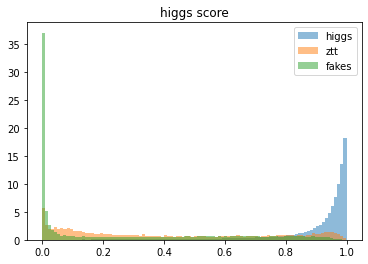

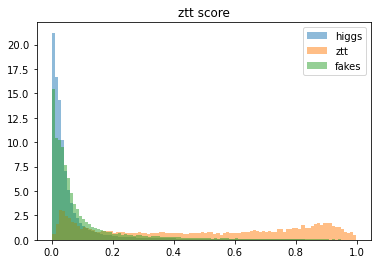

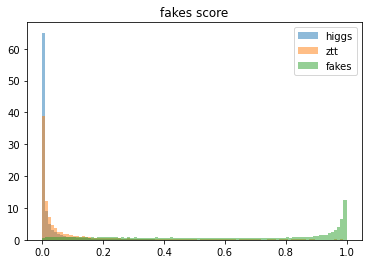

In [99]:
y_classes=xgb_clf_iso.predict(X_test)
y_pred = xgb_clf_iso.predict_proba(X_test)
labels=['higgs', 'ztt', 'fakes']
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 0][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[0]+' score')
plt.legend()
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 1][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[1]+' score')
plt.legend()
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 2][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[2]+' score')
plt.legend()
plt.show()

In [47]:
write_cm('with_iso', cm_p, cm_e)

# use smote on with iso config

In [48]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

In [49]:
df_2 = df.drop(selectors, axis=1)

In [50]:
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 1000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf_iso_smote = xgboost.XGBClassifier(**xgb_params)
# xgb_clf = xgboost.XGBClassifier()

In [51]:
df_2.drop(['y', 'wt', 'w'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis', 'iso_1', 'iso_2'],
      dtype='object')

In [52]:
X = df_2.drop(['y', 'wt', 'w'], axis=1).to_numpy()
y = df_2.y.astype(int)
w = df_2.w
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.3, random_state=1, stratify=df_2.y)

In [57]:
smote_enn = SMOTEENN(random_state=0)
# X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
X_resampled, y_resampled = smote_enn.fit_resample(np.c_[X_train, w_train], y_train)

In [60]:
X_resampled.shape

(2457407, 13)

In [61]:
X_resampled[:]

(977937, 12)

In [ ]:
X_m = 
w_m = 

In [84]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf_iso.fit(X_train, y_train, sample_weight=w_train, verbose=2, early_stopping_rounds=50, eval_set=eval_set, eval_metric = "mlogloss", sample_weight_eval_set=(w_train, w_test))
# xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, eval_metric="mlogloss")

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:40:21] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.06526	validation_1-mlogloss:1.06547
[2]	validation_0-mlogloss:1.00649	validation_1-mlogloss:1.00734
[4]	validation_0-mlogloss:0.95643	validation_1-mlogloss:0.95769
[6]	validation_0-mlogloss:0.91341	validation_1-mlogloss:0.91518
[8]	validation_0-mlogloss:0.87607	validation_1-mlogloss:0.87821
[10]	validation_0-mlogloss:0.84383	validation_1-mlogloss:0.84634
[12]	validation_0-mlogloss:0.81541	validation_1-mlogloss:0.81831
[14]	validation_0-mlogloss:0.79055	validation_1-mlogloss:0.79370
[16]	validation_0-mlogloss:0.76881	validation_1-mlogloss:0.77226
[18]	validation_0-mlogloss:0.74965	validation_1-mlogloss:0.75338
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [ ]:
eval_set = [(X_resampled, y_resampled), (X_test, y_test)]
xgb_clf_c.fit(X_resampled, y_resampled, verbose=2, early_stopping_rounds=50, eval_set=eval_set, eval_metric = "mlogloss", sample_weight_eval_set=(w_train, w_test))


# S/sqrt(B) study

In [58]:
def SsqrtBPlot(xgb_clf, X, df_1, y):
    y_pred = xgb_clf.predict_proba(X)
    y_classes = xgb_clf.predict(X)
    higgs_events = y_classes==0
    higgs_prob = y_pred[higgs_events][:, 0]
    filtered_mask = (higgs_prob>0.9) & (higgs_prob<1)
    filtered_higgs_prob = higgs_prob[filtered_mask]
    def filterprob(start, end):
        filtered_mask = (higgs_prob>start) & (higgs_prob<end)
        filtered_higgs_prob = higgs_prob[filtered_mask]
        return filtered_mask, filtered_higgs_prob
    fig, ax = plt.subplots(1, 4, sharex='col', sharey='row', figsize=(24,6))
    windows = [[0, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1]]
    for i, w in enumerate(windows):
        filtered_mask, filtered_higgs_prob = filterprob(w[0], w[1])
    #     counts = Counter(y_classes[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])])
    #     counts =Counter(y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])])
        S = df_1.w[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])][y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])]==0].sum()
        ztt = df_1.w[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])][y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])]==1].sum()
        fakes = df_1.w[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])][y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])]==2].sum()
        B = ztt + fakes
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    #     ax[i].set_xlim(w[0], w[1])
        textstr= f"S/sqrt(B)={S/np.sqrt(B):.4f}\nS={S:.3f}\nztt={ztt:.3f}\nfakes={fakes:.3f}"
        ax[i].text(0.05, 0.95, textstr, transform=ax[i].transAxes, fontsize=14, horizontalalignment='left', verticalalignment='top', bbox=props)
        ax[i].hist(filtered_higgs_prob, bins=100)
    plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

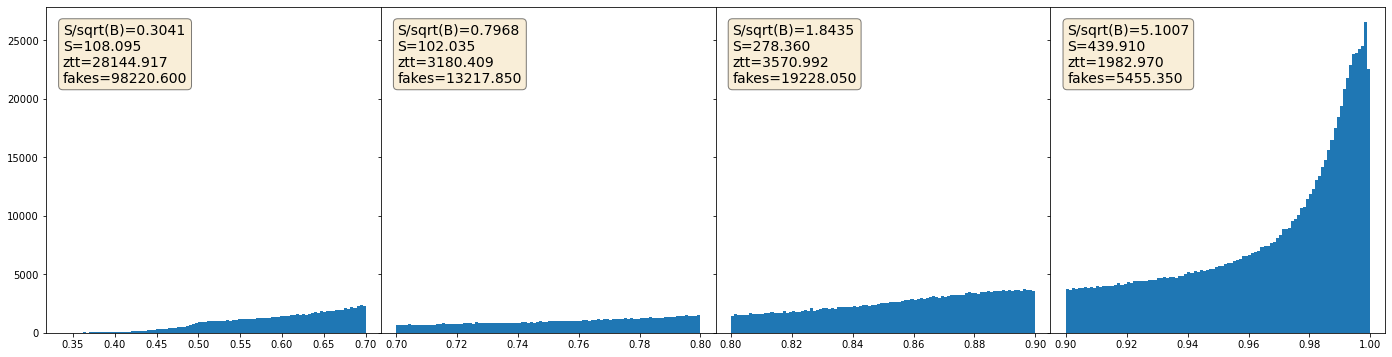

In [111]:
SsqrtBPlot(xgb_clf, X, df_1)

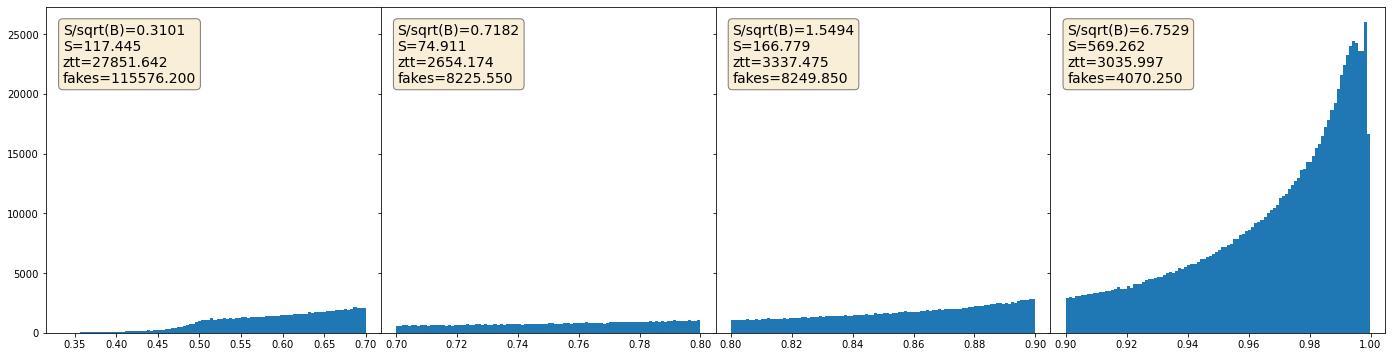

In [98]:
SsqrtBPlot(xgb_clf_iso, X_iso, df_2)

In [115]:
xgb_clf_iso.save_model('/home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/iso.json')

In [104]:
df_1.loc[:, 'y_pred']  = xgb_clf.predict(X)

In [114]:
df_1.drop(['y', 'wt'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis', 'w', 'y_pred'],
      dtype='object')

In [148]:
df_test = pd.DataFrame(X_test, columns=df_1.drop(['y', 'wt'], axis=1).columns).reset_index(drop=True)

In [147]:
(y_test==2).sum()

20166

In [149]:
df_test['y'] = y_test.to_numpy()
df_test['w'] = w_test.to_numpy()

In [150]:
df_test['y_pred'] = xgb_clf.predict(X_test)

In [151]:
df_test

,pt_1,pt_2,m_vis,svfit_mass,mjj,jpt_1,pt_tt,met,n_jets,pt_vis,w,y,y_pred
0,92.282034,53.676795,92.767455,115.830387,777.012285,111.839663,138.882213,29.351910,2.0,114.518214,0.000053,0,0
1,41.703584,40.880400,85.186898,101.254921,507.899335,98.537312,23.169485,24.799908,2.0,2.083170,0.000024,0,0
2,129.497680,81.550319,92.653429,124.638680,2601.815534,256.477620,283.144277,88.702454,4.0,195.046717,0.000063,0,0
3,42.768679,40.478256,83.106576,139.588425,970.733272,75.777211,81.928694,77.720337,1.0,6.513472,0.000157,0,0
4,52.635335,52.384945,101.074869,108.849537,169.383822,41.276124,30.110152,9.723588,3.0,39.826468,0.000056,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198848,86.956464,54.072191,84.667066,98.186611,491.818811,143.600868,144.432830,30.410059,2.0,118.070496,0.000057,0,0
198849,54.342384,50.044678,106.130171,142.722984,-9999.000000,38.905858,51.391301,56.381241,1.0,5.797828,0.000154,0,0
198850,332.635573,71.107560,85.773144,124.196709,809.351633,787.601410,691.283480,294.794250,2.0,396.512134,0.000135,0,0
198851,66.861926,42.956125,105.681926,125.633175,364.414807,94.597766,77.411184,12.334446,3.0,67.925730,0.000063,0,0
